# Lamina Monopolar Cell Connectivity Patterns
Exploratory data analysis: what variables seperate the different classes of LMCs we identified?

In [20]:
import numpy as np
import pandas as pd
from typing import Tuple, Union, List
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.decomposition import PCA
import itertools

from vis.fig_tools import subtype_cm

plt.rcdefaults()
plt.style.use('vis/lamina.mplstyle')

In [21]:
### SAVE FIGS? ###
save_figs=False
##################

In [22]:
tp = '210511'
linkdf = pd.read_pickle(f'~/Data/{tp}_lamina/{tp}_linkdf.pickle')
cxdf = pd.read_pickle(f'~/Data/{tp}_lamina/{tp}_cxdf.pickle')

subtypes = np.unique([*linkdf["pre_type"], *linkdf["post_type"]])
lmcs = [s for s in subtypes if s[0] == 'L']

all_ctypes = [p for p in itertools.product(subtypes, subtypes)]  
all_ctype_labels = [f"{pre}->{post}" for pre, post in all_ctypes]
ommatidia = np.unique(linkdf['pre_om'])

# df of interommatidial connections
criteria = ((linkdf['pre_om'] != linkdf['post_om']) & (linkdf['post_om'] != 'UNKNOWN'))
interdf = linkdf.loc[criteria]
# lists of ommatidia with or without l4s
with_l4 = np.unique([row['post_om'] for i, row in linkdf.iterrows() if row['post_type'] == 'LMC_4'])
no_l4 = [om for om in ommatidia if om not in with_l4]

In [23]:
### Assemble dataframe ###
# LMC outputs
out_counts = []
for om, r in cxdf.groupby('om'):
    for pre, rr in r.groupby('pre_type'):
        if (om in no_l4) and (pre == 'LMC_4'):
            continue
        else:
            out_counts.append({'om': om, 
                               'type': pre, 
                               'output_count': rr['n_connect'].sum()})
# data contains cols for number of overall outputs and number of inputs from each subtype
data = pd.DataFrame(out_counts)
for s in subtypes:
    data[s] = np.zeros(len(data.index))
    
inter_in = np.zeros(len(data.index), dtype=int)
for i, row in data.iterrows():
    # Home inputs
    criteria = (cxdf['om'] == row['om']) & (cxdf['post_type'] == row['type'])
    inputs = cxdf.loc[criteria, ('pre_type', 'n_connect')].set_index('pre_type').to_dict()
    data.loc[i, 3:-1] = pd.Series(inputs['n_connect'])
    # Inputs to the lmcs from outside home
    criteria = ((interdf['post_om'] == row['om']) & (interdf['post_type'] == row['type']))
    inter_in[i] = len(interdf.loc[criteria])
        
data['inter_in'] = inter_in
#display(data.loc[data["type"] == 'LMC_4'])


<ipython-input-23-844887b8b997>:22: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  data.loc[i, 3:-1] = pd.Series(inputs['n_connect'])


In [27]:
lmcs

['LMC_1', 'LMC_2', 'LMC_3', 'LMC_4', 'LMC_N']

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not [['#EA33F7#EA33F7#EA33F7#EA33F7#EA33F7#EA33F7#EA33F7#EA33F7#EA33F7#EA33F7#EA33F7#EA33F7#EA33F7#EA33F7#EA33F7#EA33F7#EA33F7#EA33F7#EA33F7#EA33F7#EA33F7#EA33F7#EA33F7#EA33F7#EA33F7#EA33F7#EA33F7#EA33F7#EA33F7']
 ['#8D2E4F#8D2E4F#8D2E4F#8D2E4F#8D2E4F#8D2E4F#8D2E4F#8D2E4F#8D2E4F#8D2E4F#8D2E4F#8D2E4F#8D2E4F#8D2E4F#8D2E4F#8D2E4F#8D2E4F#8D2E4F#8D2E4F#8D2E4F#8D2E4F#8D2E4F#8D2E4F#8D2E4F#8D2E4F#8D2E4F#8D2E4F#8D2E4F#8D2E4F']
 ['#EB512E#EB512E#EB512E#EB512E#EB512E#EB512E#EB512E#EB512E#EB512E#EB512E#EB512E#EB512E#EB512E#EB512E#EB512E#EB512E#EB512E#EB512E#EB512E#EB512E#EB512E#EB512E#EB512E#EB512E#EB512E#EB512E#EB512E#EB512E#EB512E']
 ['#F3AF3D#F3AF3D#F3AF3D#F3AF3D#F3AF3D#F3AF3D#F3AF3D#F3AF3D#F3AF3D#F3AF3D#F3AF3D#F3AF3D#F3AF3D#F3AF3D#F3AF3D#F3AF3D#F3AF3D#F3AF3D#F3AF3D#F3AF3D#F3AF3D#F3AF3D']
 ['#e08ba6#e08ba6#e08ba6#e08ba6#e08ba6#e08ba6#e08ba6#e08ba6#e08ba6#e08ba6#e08ba6#e08ba6#e08ba6#e08ba6#e08ba6#e08ba6#e08ba6#e08ba6#e08ba6#e08ba6#e08ba6#e08ba6#e08ba6#e08ba6#e08ba6#e08ba6#e08ba6#e08ba6#e08ba6']]

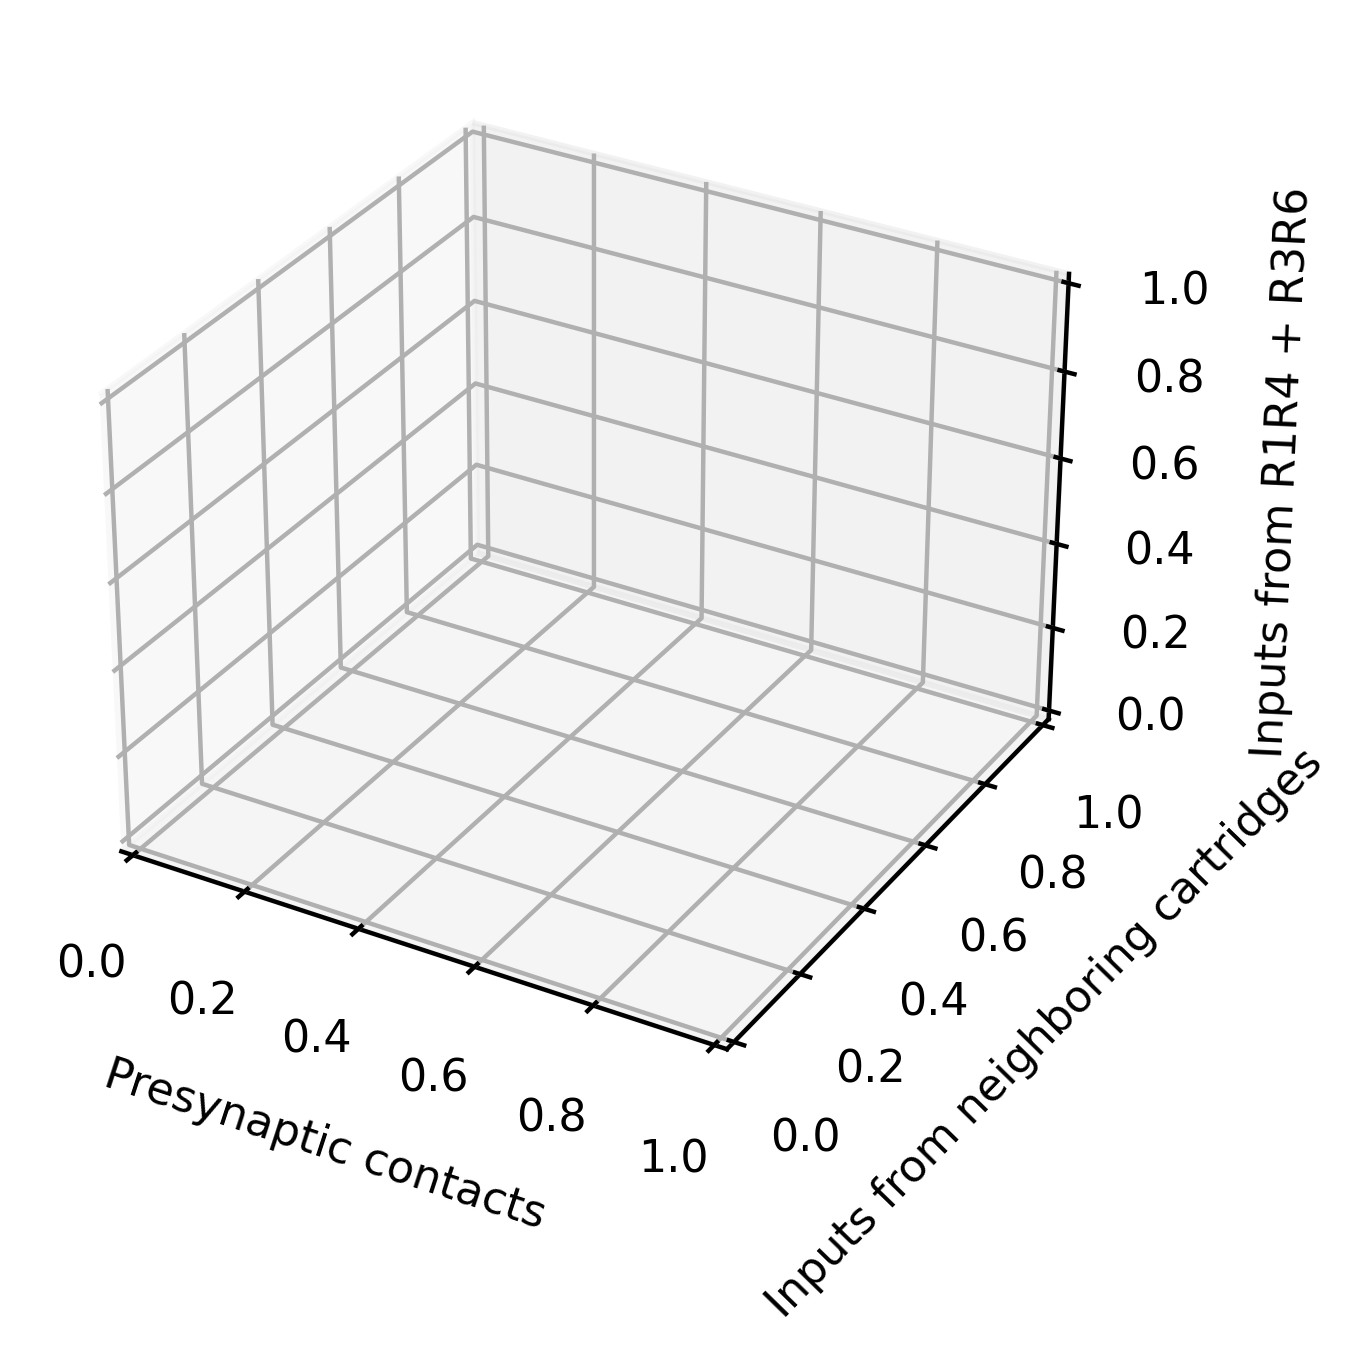

In [33]:
fig = plt.figure(figsize=[3.5, 3.5])
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('Presynaptic contacts')
ax.set_zlabel('Inputs from R1R4 + R3R6')
ax.set_ylabel('Inputs from neighboring cartridges')

c = subtype_cm()

m = {'LMC_N': 'D', 'LMC_1': 's', 'LMC_2': '^', 'LMC_3': 'o', 'LMC_4': 'P'}

X = []
Y = []
Z = []

labels = []
markers = []
colors = []


for st, rows in data.groupby('type'):
    if st in lmcs:
        infrac = rows['R1R4'] + rows['R3R6']
        X.append(rows['output_count'])
        Y.append(rows['output_count'])
        Z.append(infrac)
        
        labels.append([st * len(rows)])
        markers.append([m[st] * len(rows)])
        colors.append([c[st] * len(rows)])
        
    else:
        continue
        
        
#         ax.scatter(rows['output_count'], rows['inter_in'], infrac, 
#                    label=f"L{pre.split('_')[1]}", marker=m[pre],
#                    c=c[pre], alpha=0.5, depthshade=False)
        #ax.scatter(rows['R1R4'] + rows['R3R6'], rows['inter_in'], rows['output_count'], label=pre)
ax.scatter(X, Y, Z, 
           label=labels, 
           marker=markers, 
           c=colors)

plt.legend(bbox_to_anchor=(0.95, 1), loc='upper left', borderaxespad=0.)
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
#ax.invert_yaxis()
ax.view_init(elev=10)

plt.show()

if save_figs:
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/LMC_properties_scatter.svg')
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/LMC_properties_scatter.png')

<ipython-input-7-7dc9d03b5e94>:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


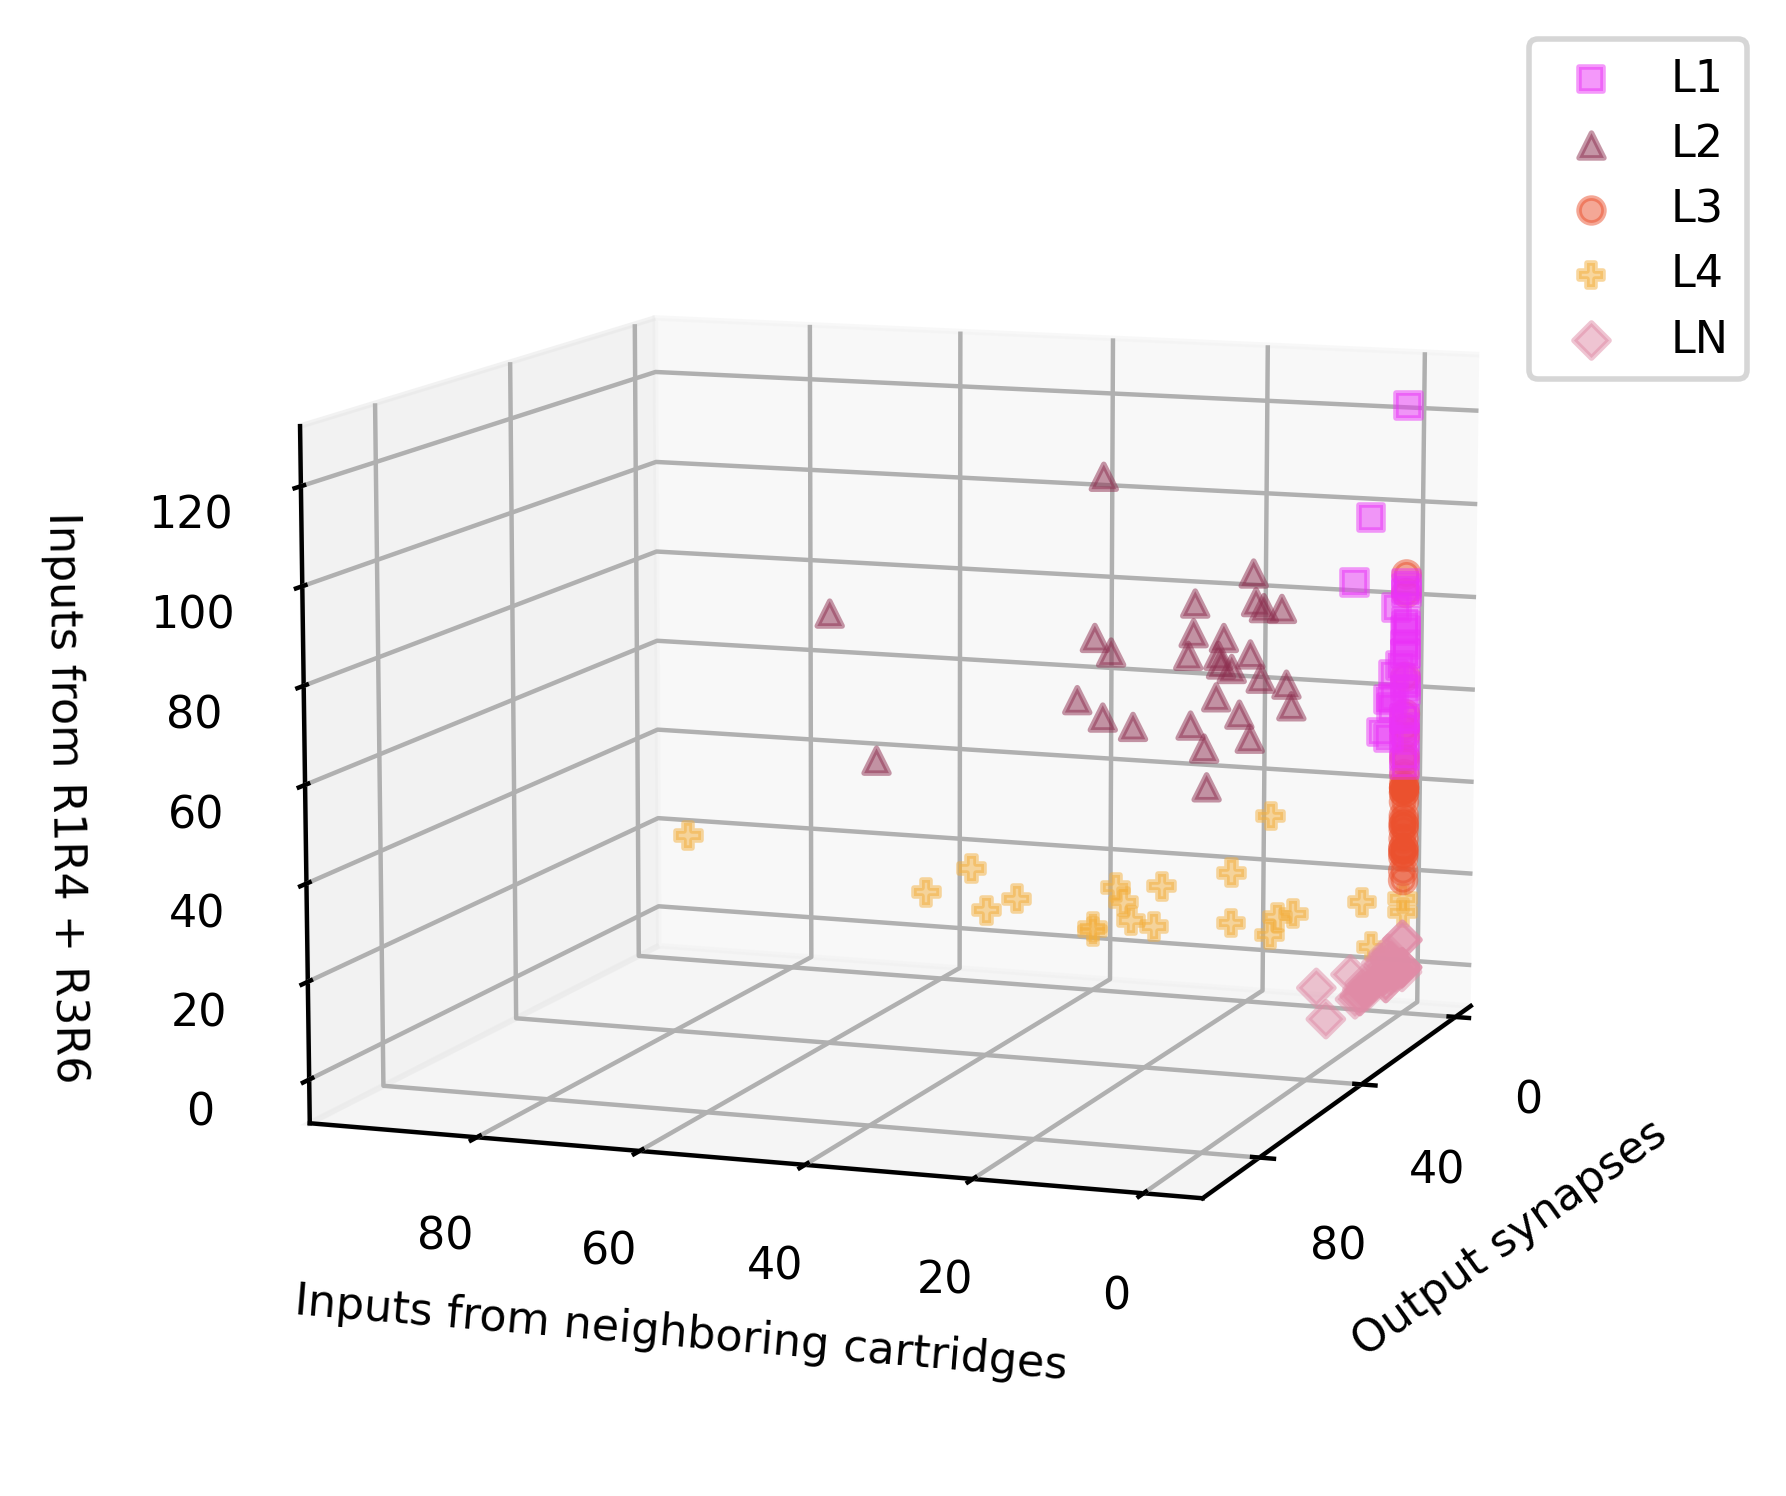

In [7]:
fig = plt.figure(figsize=[4.6, 4.6])
ax = fig.gca(projection='3d')
ax.set_xlabel('Output synapses')
ax.set_zlabel('Inputs from R1R4 + R3R6')
ax.set_ylabel('Inputs from neighboring cartridges')

c = subtype_cm()

m = {'LMC_N': 'D', 'LMC_1': 's', 'LMC_2': '^', 'LMC_3': 'o', 'LMC_4': 'P'}

for pre, rows in data.groupby('type'):
    if pre not in lmcs:
        continue
    else:
        
        infrac = rows['R1R4'] + rows['R3R6']
        ax.scatter(rows['output_count'], rows['inter_in'], infrac, 
                   label=f"L{pre.split('_')[1]}", marker=m[pre],
                   c=c[pre], alpha=0.5, depthshade=True)
        #ax.scatter(rows['R1R4'] + rows['R3R6'], rows['inter_in'], rows['output_count'], label=pre)
plt.legend(bbox_to_anchor=(0.95, 1), loc='upper left', borderaxespad=0.)
# maxx = max(data['R1R4'] + data['R3R6'])
# maxy = max(data['inter_in'])

# ax.set_xlim([0, maxx + maxx % 5])
# ax.set_ylim([0, maxy + maxy % 5])
# ax.set_zlim()
ax.view_init(elev=10, azim=200)
ax.autoscale(enable=True, tight=True)
ax.invert_yaxis()
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
#ax.tick_params(labelrotation=Fals
plt.show()

if save_figs:
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/LMC_properties_scatter.svg')
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/LMC_properties_scatter.png')

In [8]:
data

,om,type,output_count,LMC_1,LMC_2,LMC_3,LMC_4,LMC_N,R1R4,R2R5,R3R6,R7,R7p,R8,UNKNOWN,centri,inter_in
0,A0,LMC_1,0.0,0.0,20.0,0.0,0.0,3.0,38.0,38.0,46.0,0.0,0.0,0.0,NaN,0.0,0
1,A0,LMC_2,54.0,0.0,0.0,0.0,0.0,0.0,36.0,48.0,31.0,0.0,0.0,0.0,NaN,0.0,17
2,A0,LMC_3,0.0,0.0,3.0,0.0,0.0,4.0,24.0,39.0,22.0,0.0,0.0,0.0,NaN,0.0,0
3,A0,LMC_4,0.0,0.0,18.0,0.0,0.0,0.0,7.0,22.0,12.0,0.0,0.0,0.0,NaN,0.0,94
4,A0,LMC_N,8.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,NaN,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,E7,R3R6,110.0,0.0,2.0,0.0,0.0,1.0,5.0,1.0,2.0,0.0,0.0,0.0,NaN,0.0,0
337,E7,R7,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,NaN,0.0,0
338,E7,R7p,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0,1.0,0.0,0.0,0.0,NaN,0.0,0
339,E7,R8,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0


/mnt/home/nchua/miniconda3/envs/wasp-lite/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


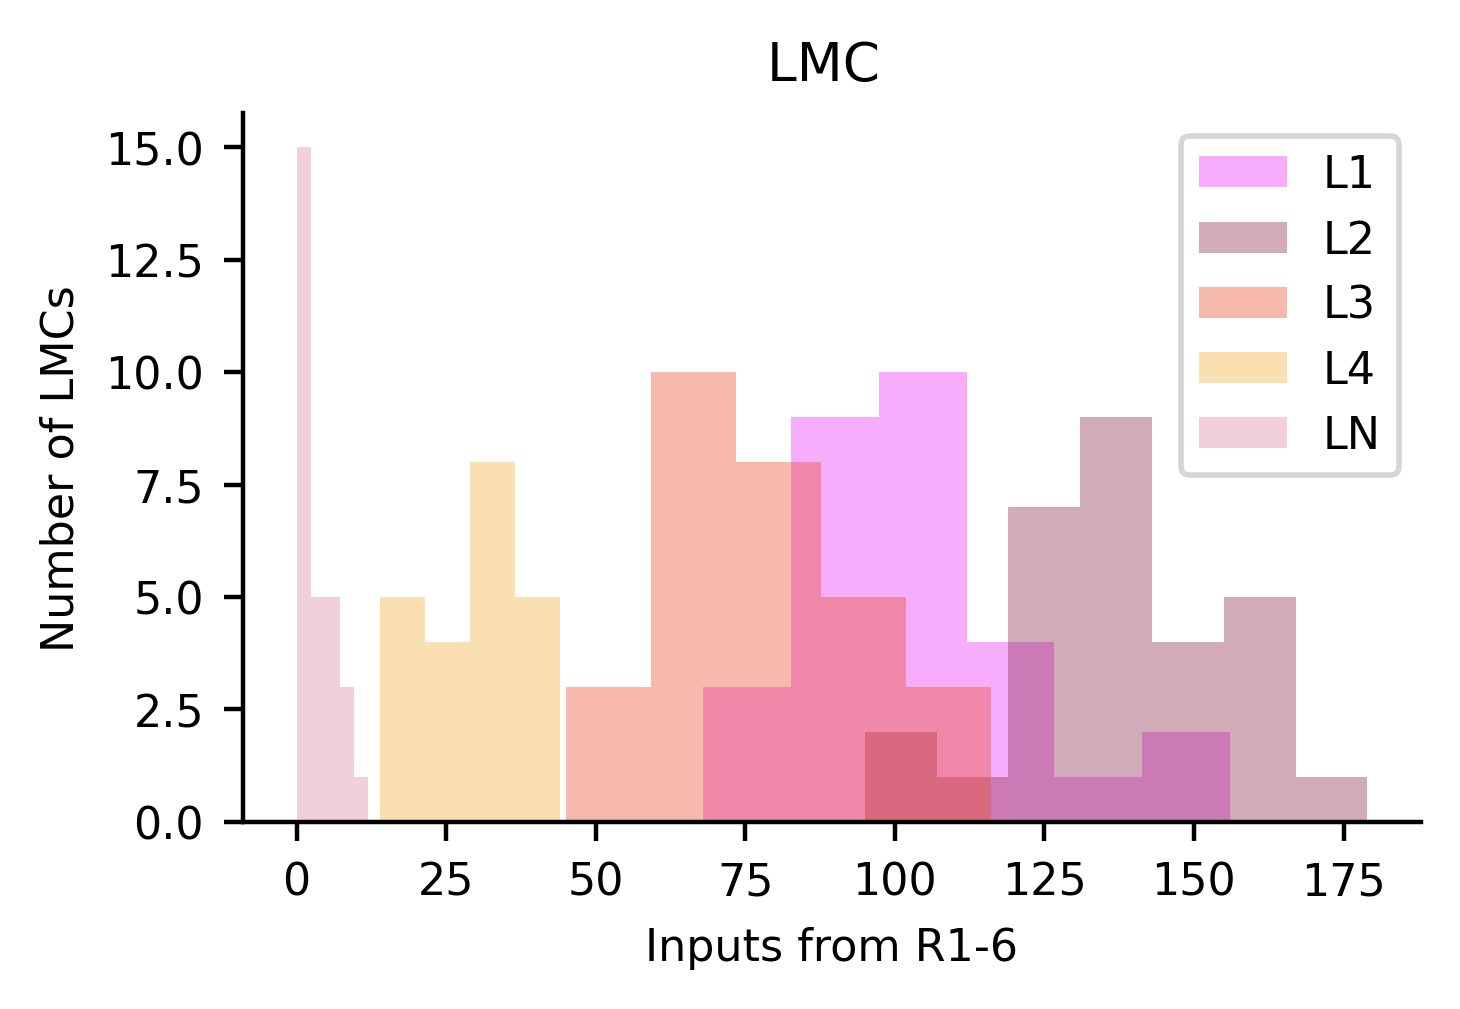

In [9]:
fig, ax = plt.subplots(1)
ax.set_title('LMC ')
ax.set_xlabel('Inputs from R1-6')
ax.set_ylabel('Number of LMCs')

for post in lmcs:
    x = data.loc[data['type'] == post, ('R2R5', 'R1R4', 'R3R6')].sum(axis=1)
    sns.distplot(x, ax=ax, color=c[post], label=post[0] + post[-1], kde=False)

ax.legend()

## LN receives significantly fewer R1-6 inputs than the anucleate LMC subtypes

In [10]:
nuc = data.loc[data['type'] == 'LMC_N', ('R2R5', 'R1R4', 'R3R6')].sum(axis=1)

anuc = data.loc[data['type'].isin(['LMC_1', 'LMC_2', 'LMC_3', 'LMC_4']), 
                ('R2R5', 'R1R4', 'R3R6')].sum(axis=1)

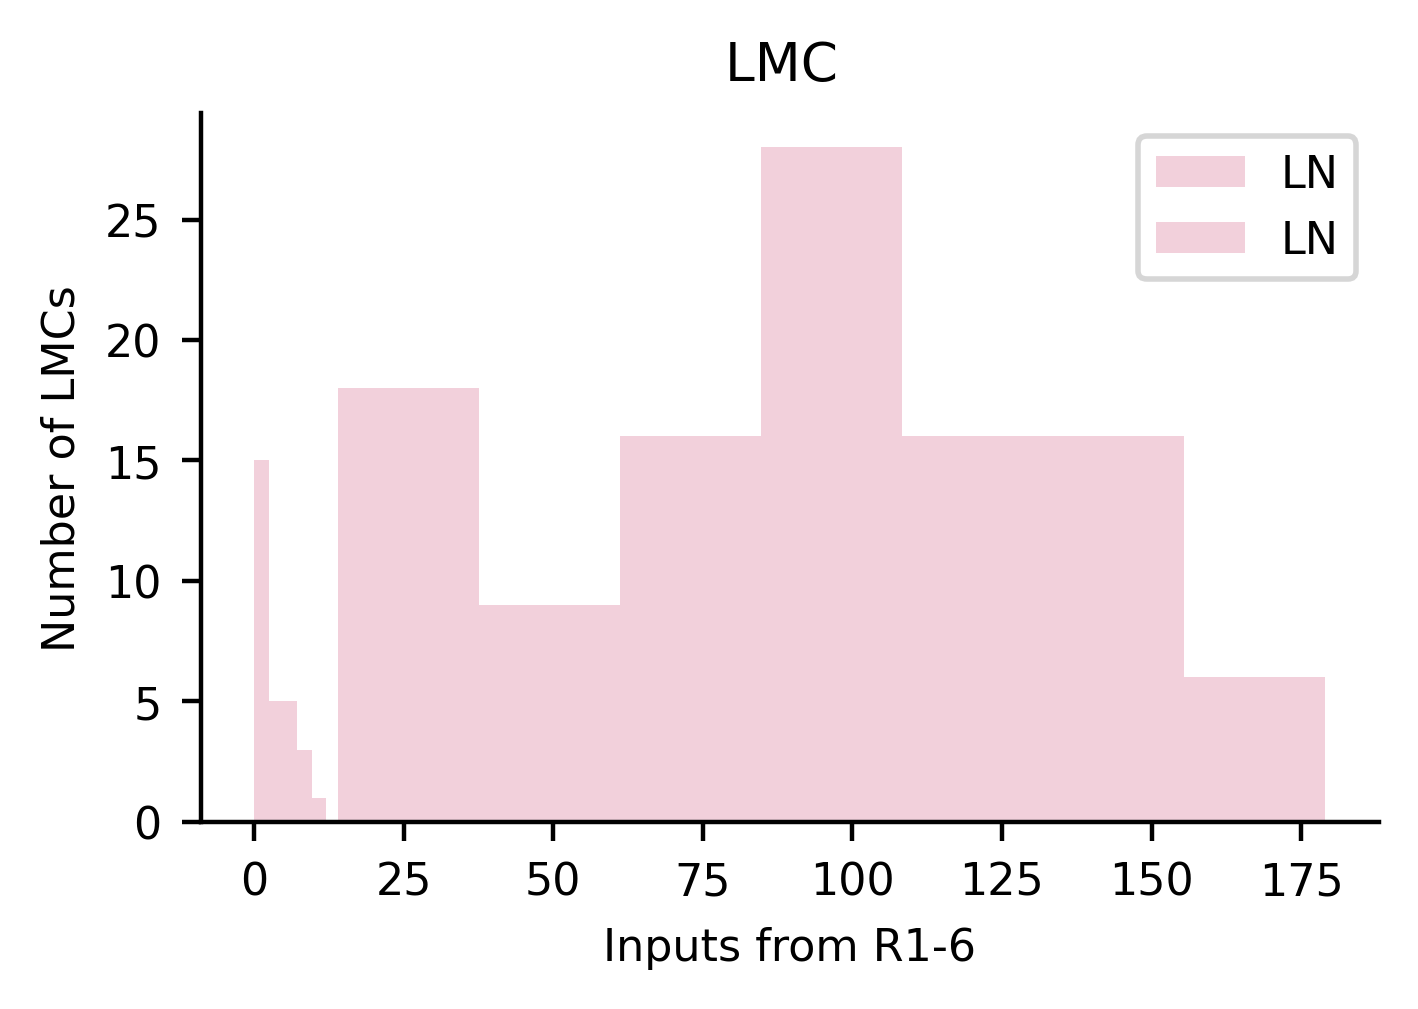

In [11]:
fig, ax = plt.subplots(1)
ax.set_title('LMC ')
ax.set_xlabel('Inputs from R1-6')
ax.set_ylabel('Number of LMCs')

x = data.loc[data['type'] == 'LMC_N', ('R2R5', 'R1R4', 'R3R6')].sum(axis=1)
sns.distplot(x, ax=ax, color=c['LMC_N'], label='LN', kde=False)

anucleate = data.loc[data['type'].isin(['LMC_1', 'LMC_2', 'LMC_3', 'LMC_4'])]
x = anucleate.loc[:, ('R2R5', 'R1R4', 'R3R6')].sum(axis=1)
sns.distplot(x, ax=ax, color=c[post], label=post[0] + post[-1], kde=False)
ax.legend()

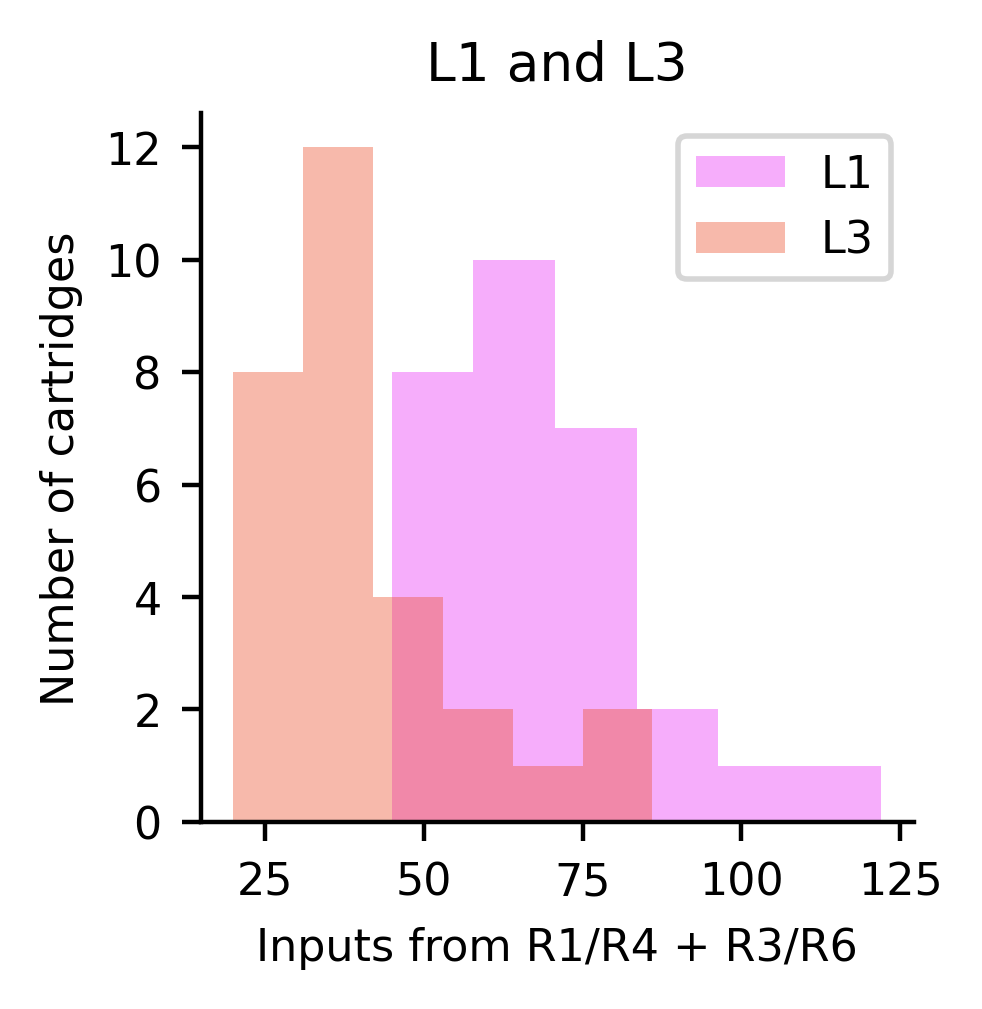

In [12]:
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])
ax.set_title('L1 and L3')
ax.set_xlabel('Inputs from R1/R4 + R3/R6')
ax.set_ylabel('Number of cartridges')
for post in ['LMC_1', 'LMC_3']:
    
    x = data.loc[data['type'] == post, ('R1R4', 'R3R6')].sum(axis=1)
    sns.distplot(x, ax=ax, color=c[post], kde=False,
                hist_kws={'label': post[0] + post[-1]})
ax.legend()

Index(['LMC_1', 'LMC_2', 'LMC_3', 'LMC_4', 'LMC_N', 'R1R4', 'R2R5', 'R3R6',
       'R7', 'R7p', 'R8', 'centri'],
      dtype='object')

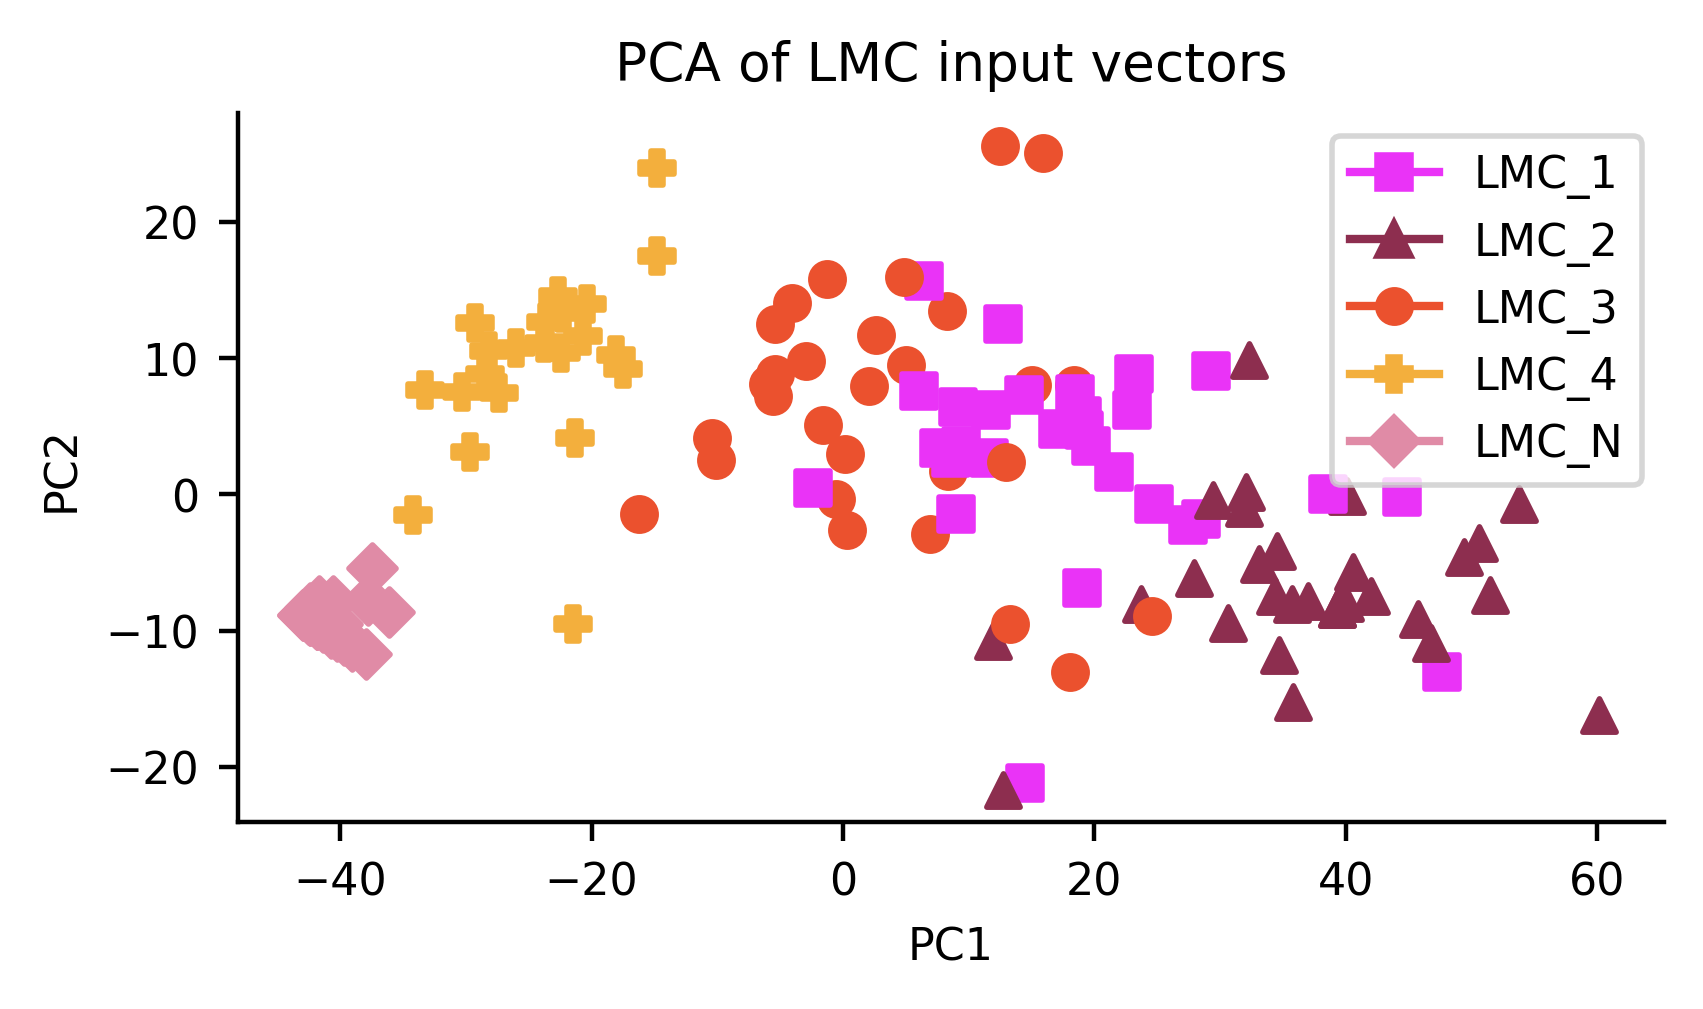

array([[ 5.22999532e-03,  8.19470073e-02,  0.00000000e+00,
         6.74792803e-05,  2.86957502e-02,  5.69339869e-01,
         6.15632657e-01,  5.37849309e-01,  0.00000000e+00,
         7.38055568e-04,  7.68275621e-05,  0.00000000e+00],
       [ 7.68545986e-03,  7.72335713e-01, -1.11022302e-16,
         2.62468771e-04,  7.05117231e-02, -3.35261774e-01,
         4.52714030e-01, -2.84801699e-01,  0.00000000e+00,
        -1.99367297e-03,  2.75852693e-04,  0.00000000e+00]])

In [13]:
# PCA all LMCs by their INPUT VECTORS
pca = PCA(n_components=2)
lmc_ins = data.loc[[i for i, t in enumerate(data['type']) if t in lmcs], 
                   ('om', 'type', *subtypes)].drop('UNKNOWN', axis=1).reset_index()

X = lmc_ins.iloc[:, 3:]
display(X.columns)
X_r = pca.fit(X).transform(X)

fig = plt.figure(figsize=[4.6, 2.3])
ax = fig.gca()
ax.set_title("PCA of LMC input vectors") 
             #f"explained variance ratio (first two PCs): {pca.explained_variance_ratio_}")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

sts = []
for i, row in lmc_ins.iterrows():
    ax.scatter(X_r[i, 0], X_r[i, 1], color=c[row['type']], label=row['type'], marker=m[row['type']])
    sts.append(row['type'])
legend_elements = []

for s in sorted(np.unique(sts)):
    legend_elements.append(Line2D([0], [0], marker=m[s], color=c[s], label=s))
ax.legend(handles=legend_elements)
plt.show()

display(pca.components_)

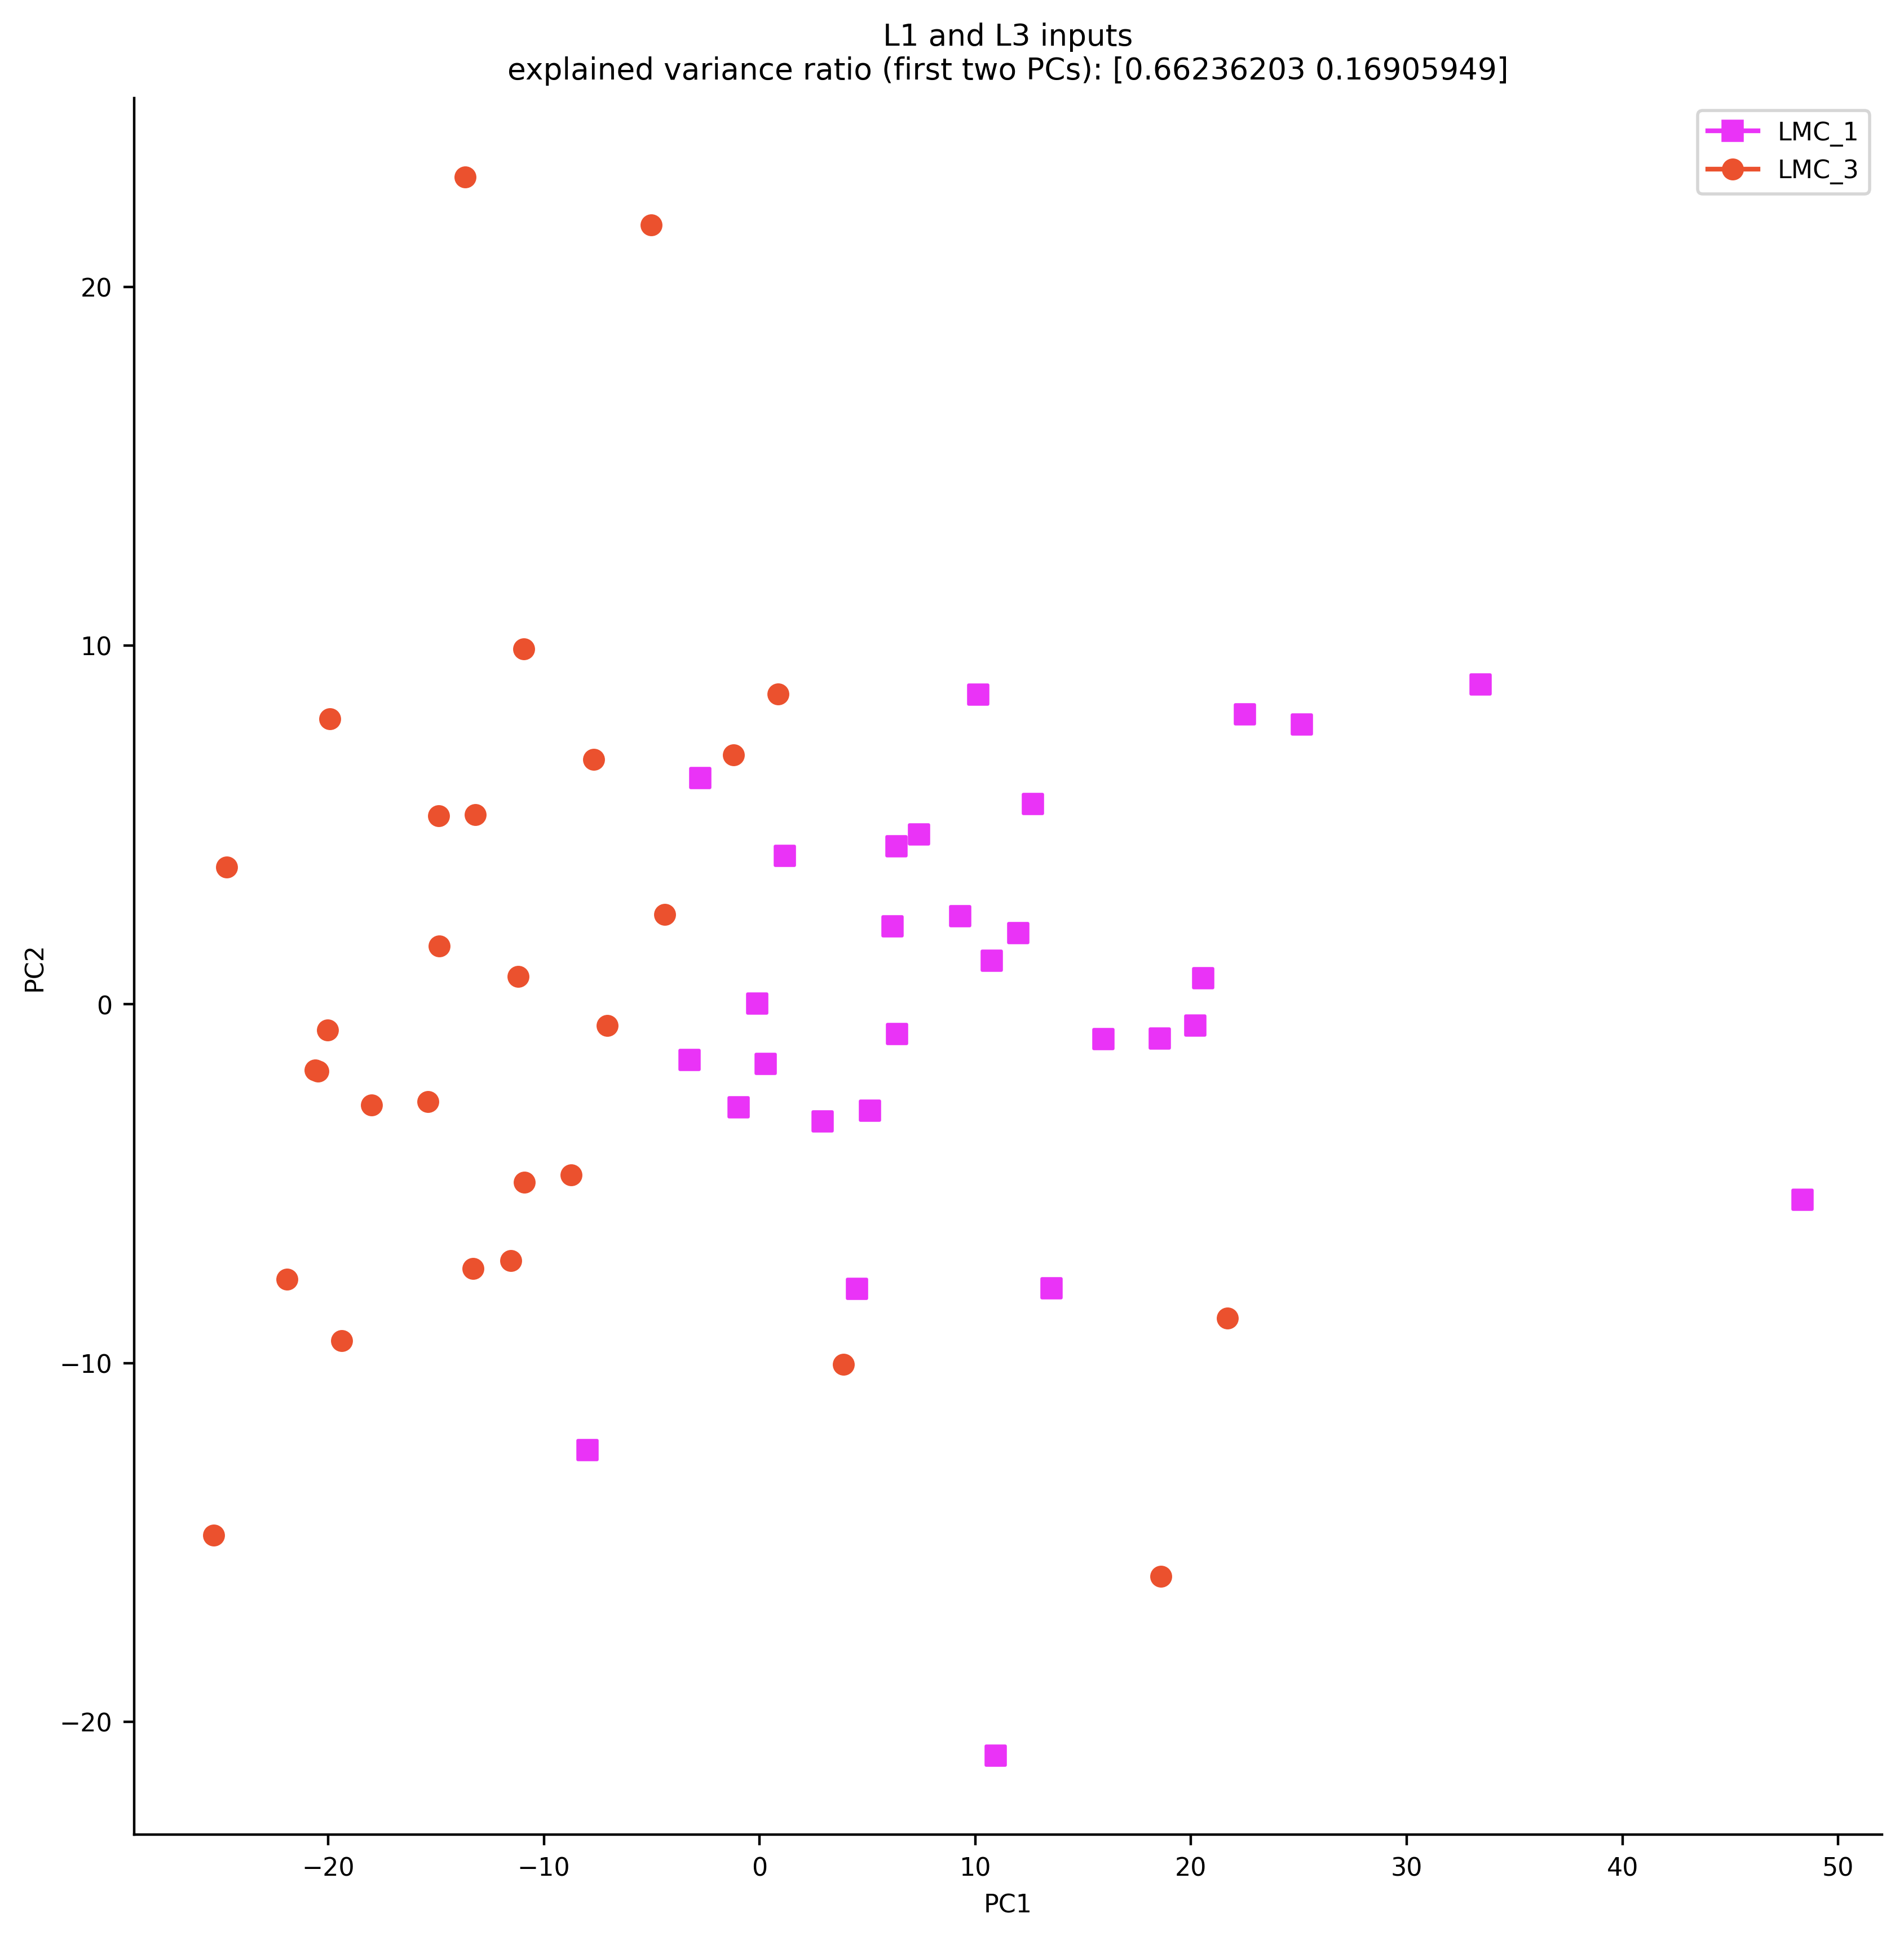

array([[-4.93412120e-03,  2.14948277e-01,  1.11022302e-16,
        -6.22849969e-04,  1.51030064e-02,  7.36891096e-01,
         2.04618987e-02,  6.40402093e-01, -0.00000000e+00,
         1.54455134e-03,  1.92601916e-05, -0.00000000e+00],
       [ 3.84423503e-02,  5.37744697e-01,  8.32667268e-17,
         7.95305980e-04,  7.79974299e-02, -1.65036310e-01,
         8.21986640e-01, -1.83823047e-02, -0.00000000e+00,
        -5.60832067e-03, -4.61035414e-04, -0.00000000e+00]])

In [29]:
# PCA L1 and L3 by their INPUT VECTORS
pca = PCA(n_components=2)
lmc_ins = data.loc[[i for i, t in enumerate(data['type']) if t in ('LMC_1', 'LMC_3')], 
                   ('om', 'type', *subtypes)].drop('UNKNOWN', axis=1).reset_index()

X = lmc_ins.iloc[:, 3:]
X_r = pca.fit(X).transform(X)

fig = plt.figure(figsize=[10, 10])
ax = fig.gca()
ax.set_title("L1 and L3 inputs\n" + 
             f"explained variance ratio (first two PCs): {pca.explained_variance_ratio_}")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
sts = []
for i, row in lmc_ins.iterrows():
    ax.scatter(X_r[i, 0], X_r[i, 1], color=c[row['type']], label=row['type'], marker=m[row['type']])
    sts.append(row['type'])
legend_elements = []
for s in sorted(np.unique(sts)):
    legend_elements.append(Line2D([0], [0], marker=m[s], color=c[s], label=s))
ax.legend(handles=legend_elements)
plt.show()

display(pca.components_)

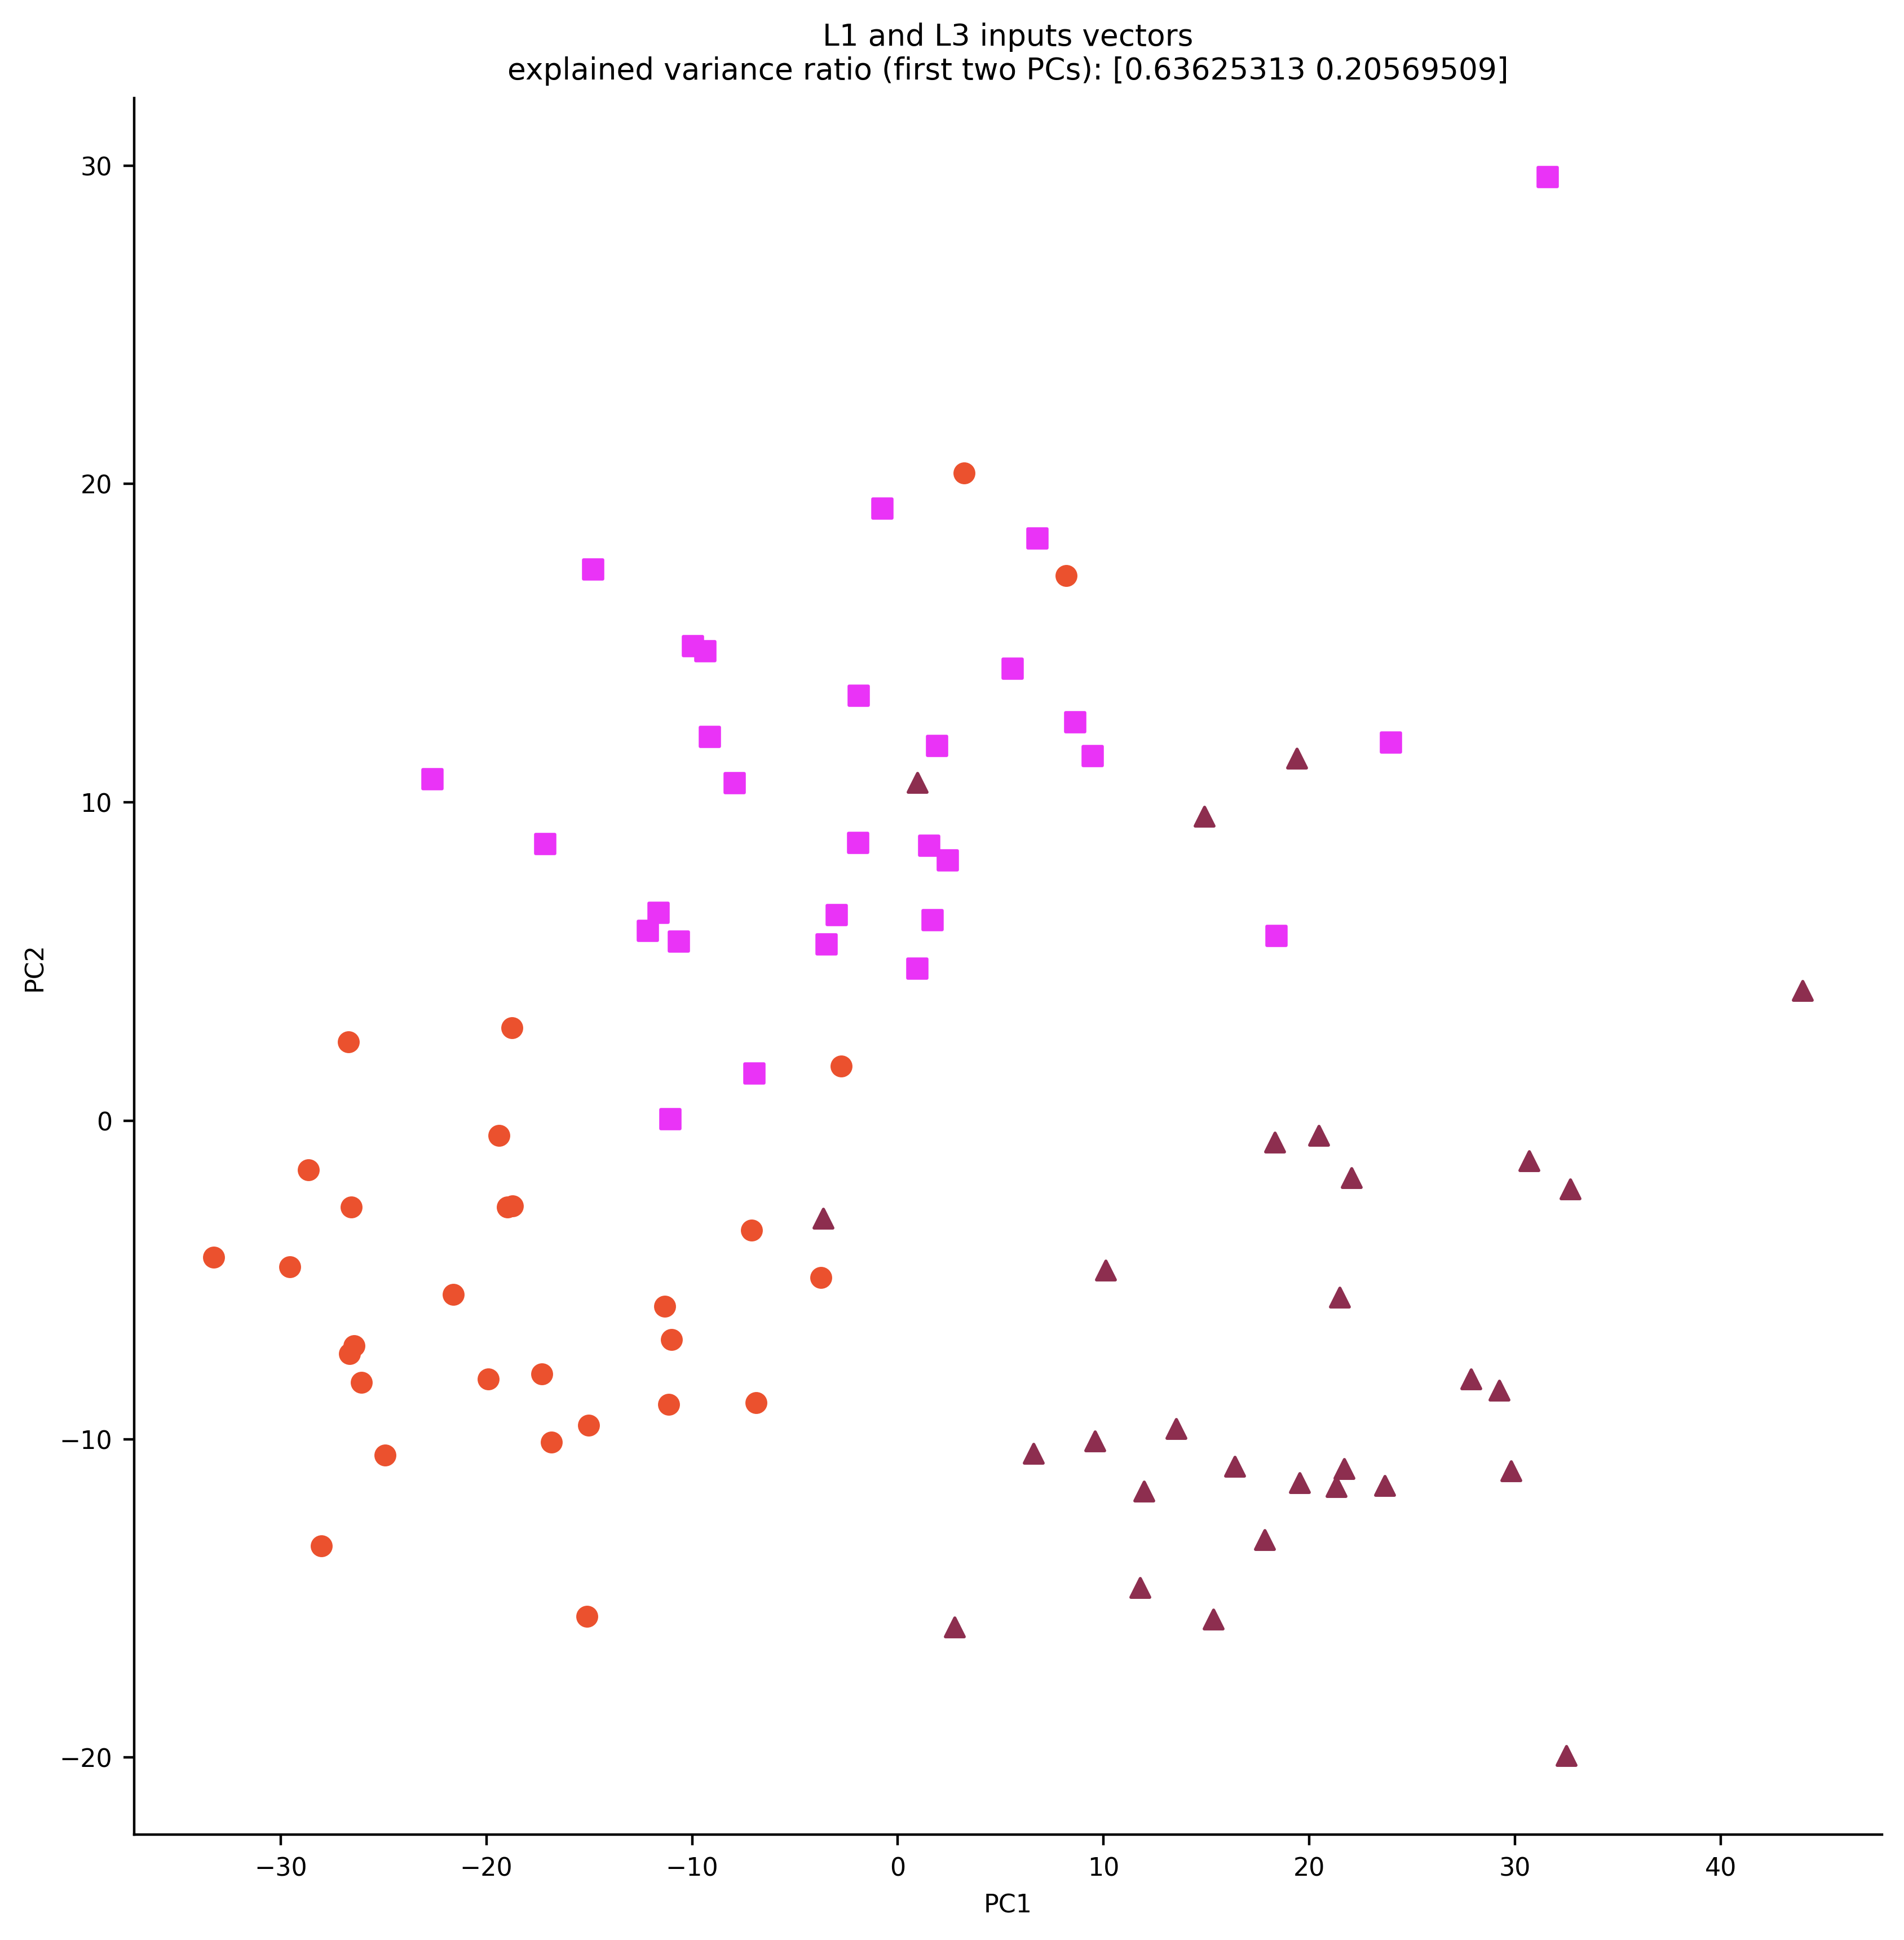

{'copy': True,
 'iterated_power': 'auto',
 'n_components': 2,
 'random_state': None,
 'svd_solver': 'auto',
 'tol': 0.0,
 'whiten': False}

In [30]:
# PCA L1 and L3 by their INPUT VECTORS
pca = PCA(n_components=2)
lmc_ins = data.loc[[i for i, t in enumerate(data['type']) if t in ('LMC_1', 'LMC_2', 'LMC_3')], 
                   ('om', 'type', *subtypes)].drop('UNKNOWN', axis=1).reset_index()

X = lmc_ins.iloc[:, 3:]
X_r = pca.fit(X).transform(X)

fig = plt.figure(figsize=[10, 10])
ax = fig.gca()
ax.set_title("L1 and L3 inputs vectors\n" + 
             f"explained variance ratio (first two PCs): {pca.explained_variance_ratio_}")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
for i, row in lmc_ins.iterrows():
    ax.scatter(X_r[i, 0], X_r[i, 1], color=c[row['type']], label=row['type'], marker=m[row['type']])

plt.show()

display(pca.get_params())

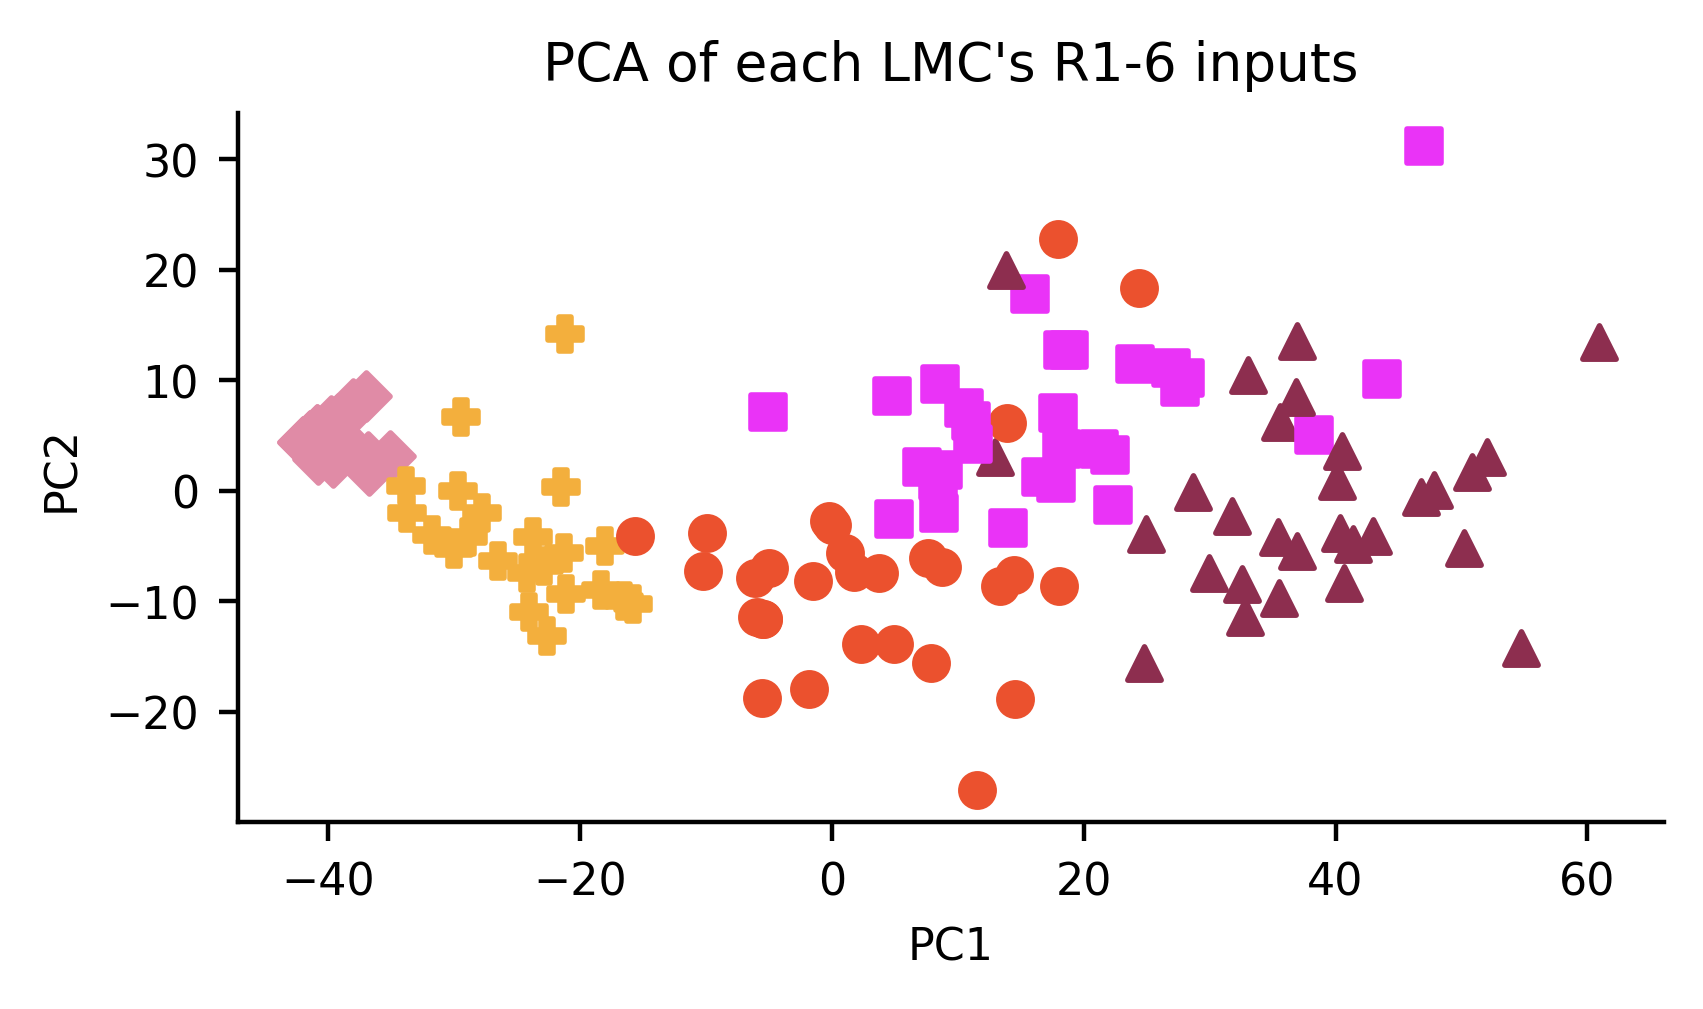

(138, 2)

In [40]:
# PCA all LMCs by their SHORT PHOTORECEPTOR INPUT VECTORS
pca = PCA(n_components=2)
lmc_ins = data.loc[[i for i, t in enumerate(data['type']) if t in lmcs], 
                   ('om', 'type', *subtypes)].drop('UNKNOWN', axis=1).reset_index()

X = lmc_ins.loc[:, ('R1R4', 'R2R5', 'R3R6')]
X_r = pca.fit(X).transform(X)

fig = plt.figure(figsize=[4.6, 2.3])
ax = fig.gca()
ax.set_title("PCA of each LMC's R1-6 inputs")
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
             #f"explained variance ratio (first two PCs): {pca.explained_variance_ratio_}")
for i, row in lmc_ins.iterrows():
    ax.scatter(X_r[i, 0], X_r[i, 1], color=c[row['type']], label=row['type'], marker=m[row['type']])

plt.show()

display(X_r.shape)

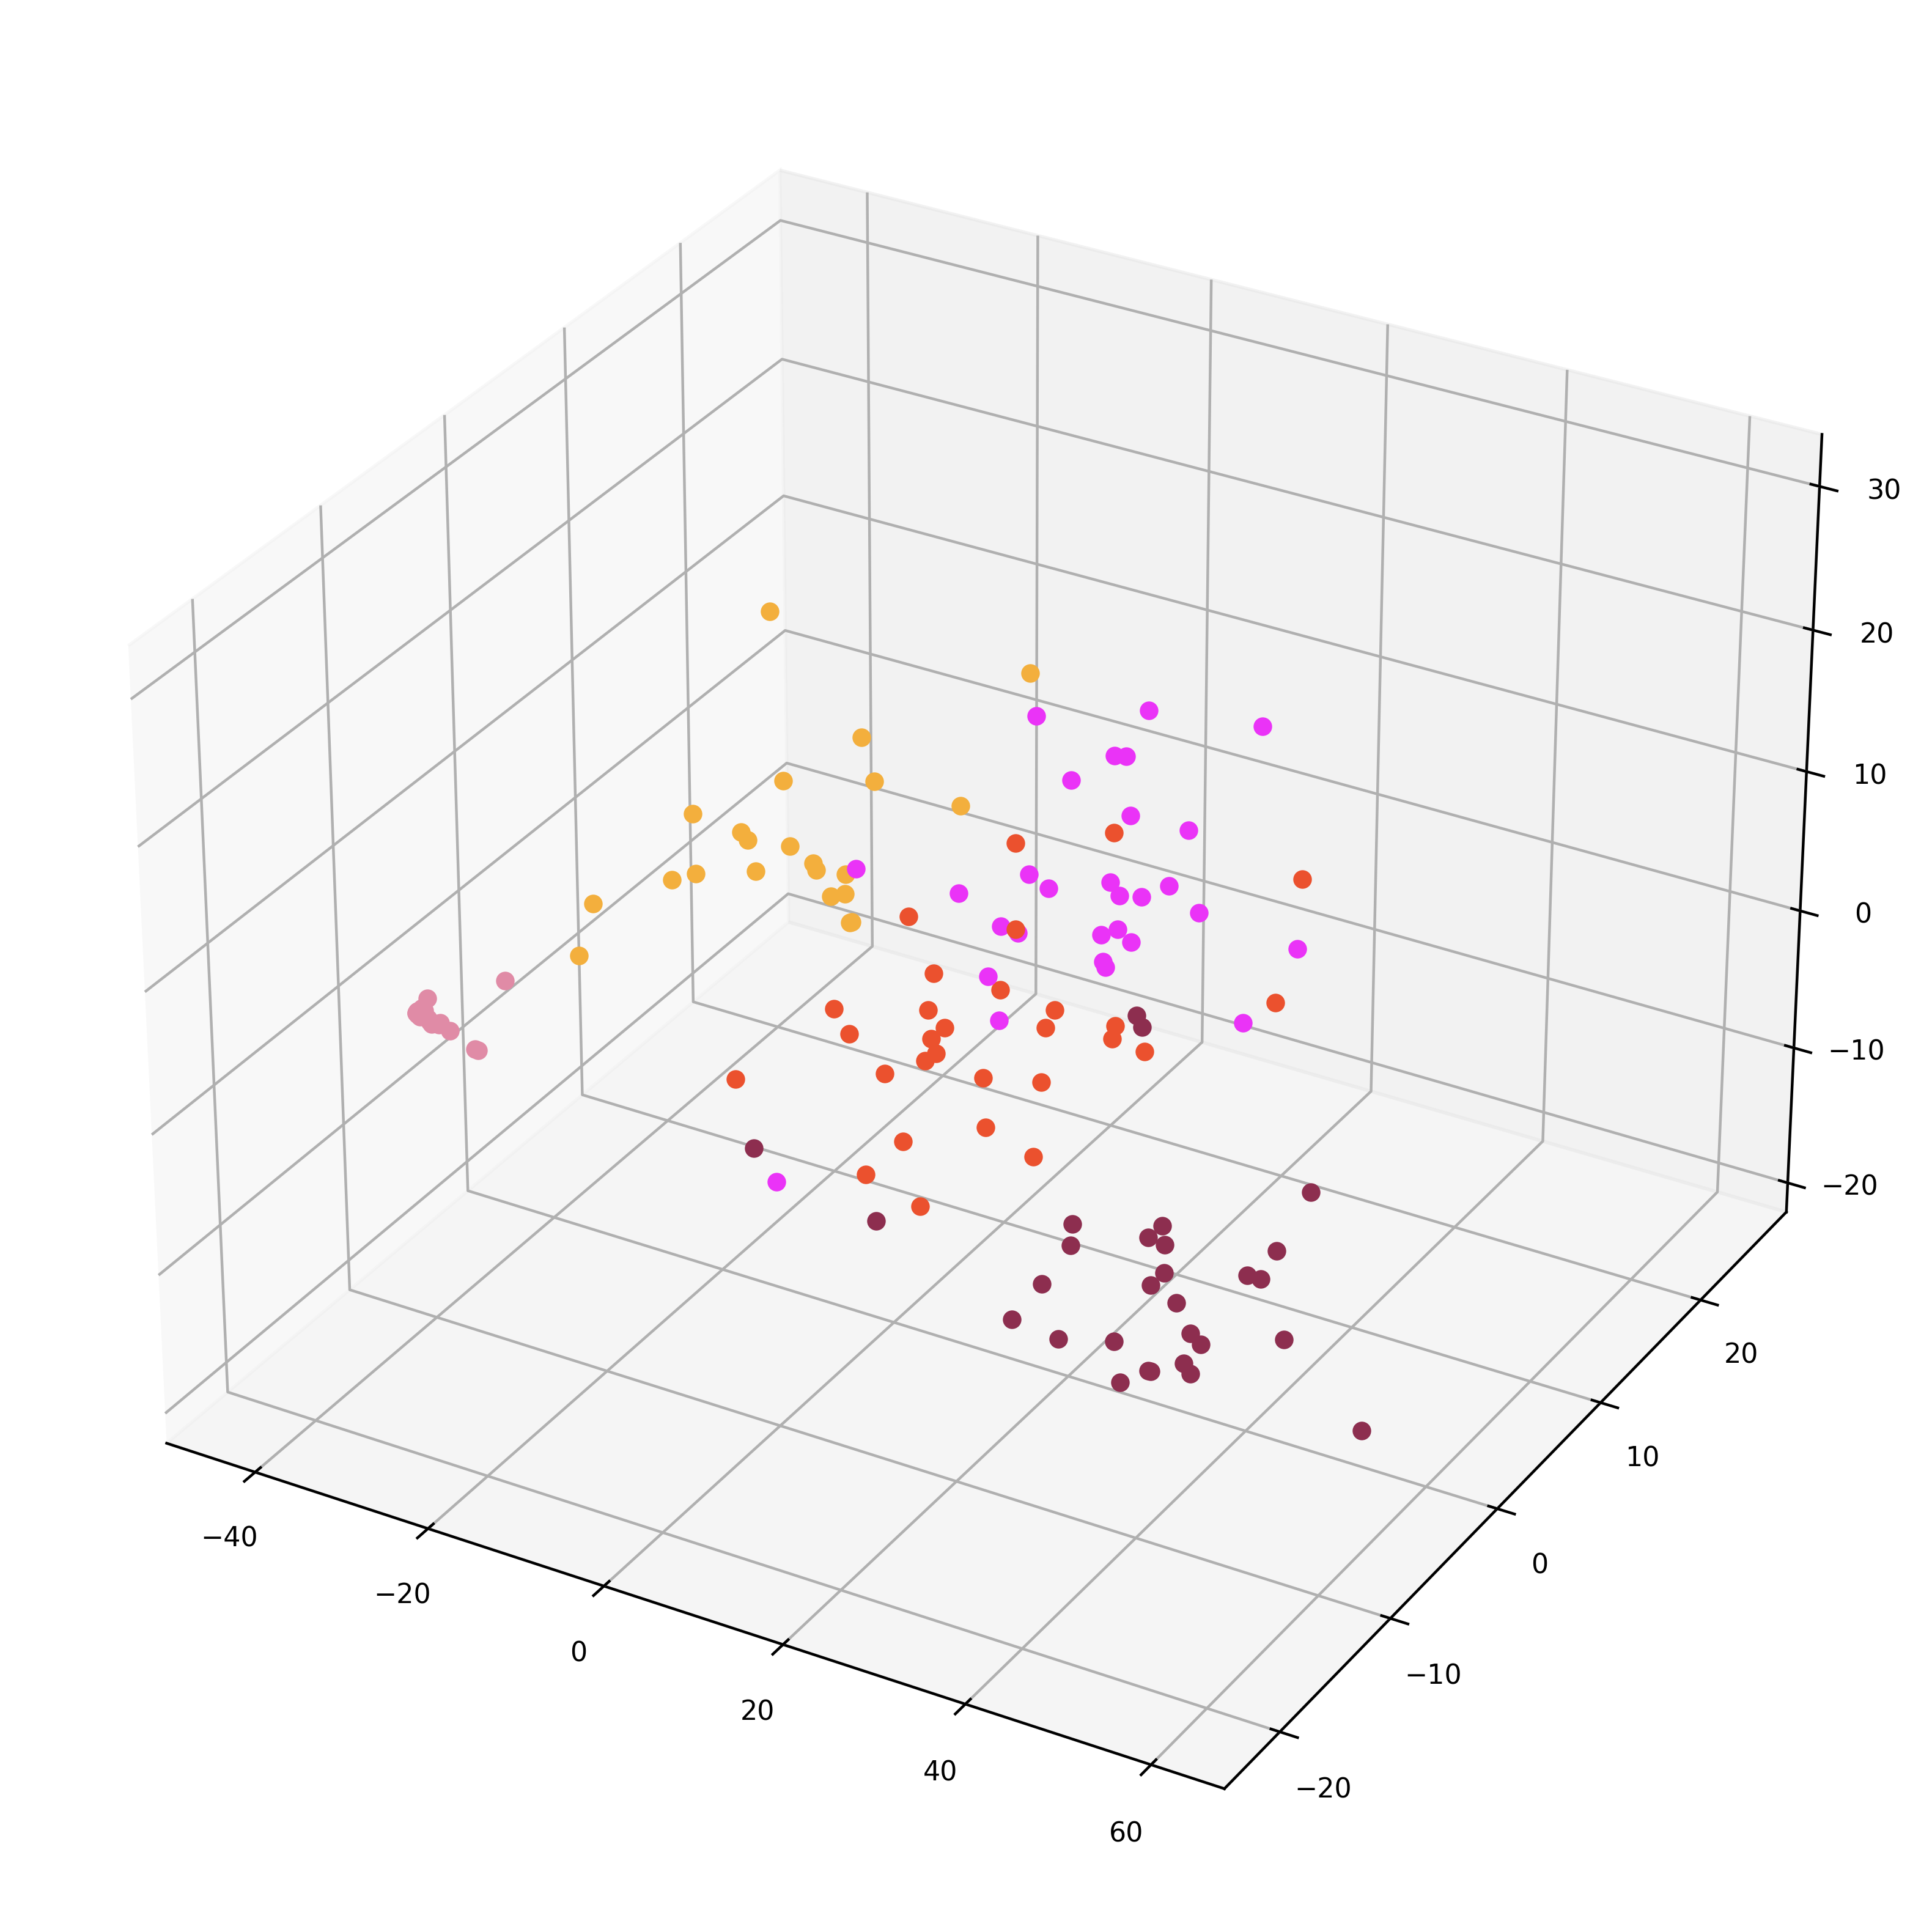

In [32]:
# PCA all LMCs by their INPUT VECTORS
pca = PCA(n_components=3)

X = lmc_ins.iloc[:, 3:]
X_r = pca.fit(X).transform(X)

fig = plt.figure(figsize=[10, 10])
ax = fig.gca(projection='3d')
for i, row in lmc_ins.iterrows():
    ax.scatter(X_r[i, 0], X_r[i, 1], X_r[i, 2], color=c[row['type']], label=row['type'])
plt.show()
ax.legend()
#display(X_r)

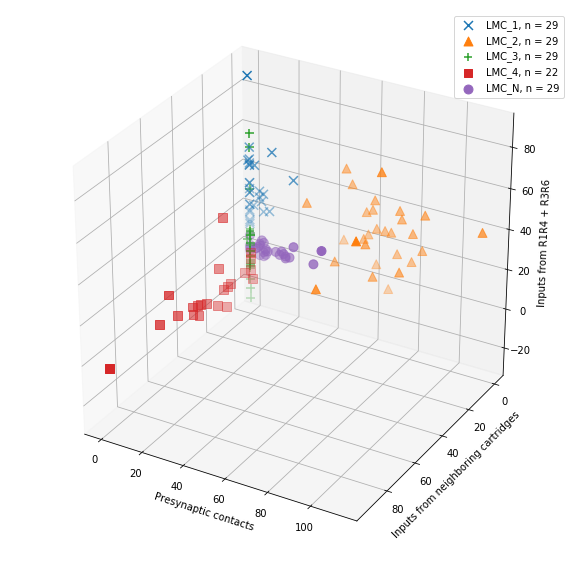

In [111]:
fig = plt.figure(figsize=[10, 10])
ax = fig.gca(projection='3d')
ax.set_xlabel('Presynaptic contacts')
ax.set_zlabel('Inputs from R1R4 + R3R6')
ax.set_ylabel('Inputs from neighboring cartridges')

for pre, rows in data.groupby('type'):
    if pre not in lmcs:
        continue
    else:
        #infrac = (rows['R1R4'] + rows['R3R6']) / (rows.filter(items=subtypes, axis=1).sum(axis=1))
        #infrac = (rows['R1R4'] + rows['R3R6']) / (rows['R1R4'] + rows['R2R5'] + rows['R3R6'])
        #infrac = rows['R1R4'] + rows['R3R6']
        infrac = rows['R1R4'] + rows['R3R6'] - rows['R2R5']
        ax.scatter(rows['output_count'], rows['inter_in'], infrac, 
                   label=f"{pre}, n = {len(rows)}", marker=m[pre], s=80, depthshade=True)
        #ax.scatter(rows['R1R4'] + rows['R3R6'], rows['inter_in'], rows['output_count'], label=pre)
ax.legend()

ax.invert_yaxis()
ax.view_init()
plt.show()

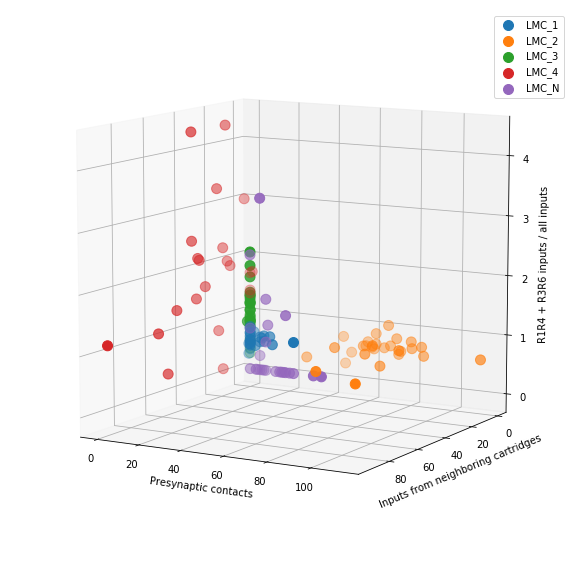

In [98]:
fig = plt.figure(figsize=[10, 10])
ax = fig.gca(projection='3d')
ax.set_xlabel('Presynaptic contacts')
ax.set_ylabel('Inputs from neighboring cartridges')
ax.set_zlabel('R1R4 + R3R6 inputs / all inputs')

for pre, rows in data.groupby('type'):
    if pre not in lmcs:
        continue
    else:
        #infrac = (rows['R1R4'] + rows['R3R6']) / (rows.filter(items=subtypes, axis=1).sum(axis=1))
        #infrac = (rows['R1R4'] + rows['R3R6']) / (rows['R1R4'] + rows['R2R5'] + rows['R3R6'])
        infrac = rows['R2R5'] / (rows['R1R4'] + rows['R3R6']) 
        #infrac = rows['R1R4'] + rows['R3R6']
        #s = rows.filter(items=subtypes, axis=1).sum(axis=1) + 50
        ax.scatter(rows['output_count'], rows['inter_in'], infrac, label=pre, s=100, depthshade=True)
        #ax.scatter(rows['R1R4'] + rows['R3R6'], rows['inter_in'], rows['output_count'], label=pre)
ax.legend()

ax.invert_yaxis()
ax.view_init(elev=10)
plt.show()

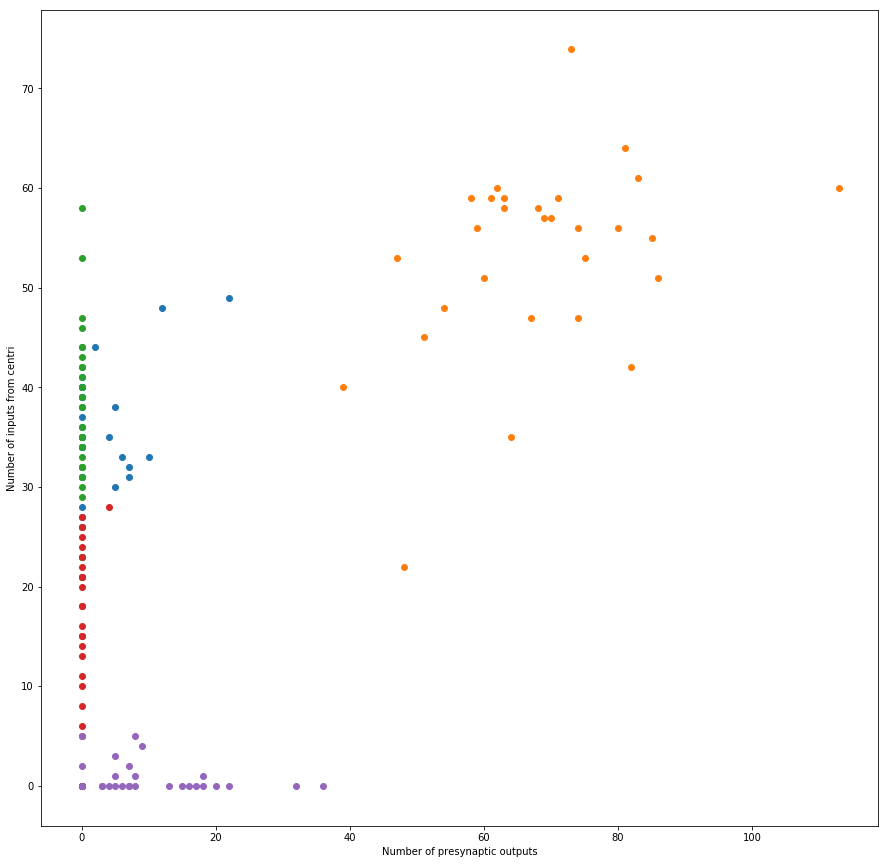

In [122]:
fig, ax = plt.subplots(1, figsize=[15, 15])
ax.set_xlabel('Number of presynaptic outputs')
ax.set_ylabel('Number of inputs from centri')

for pre, rows in data.groupby('type'):
    if pre not in lmcs:
        continue
    else:
        ax.scatter(x=rows['output_count'], y=rows['R2R5'])